In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
file_path = '../dataset/2021Yan-SP-HEA'
data_file = '2021Yan_feature_engineered.csv'
df = pd.read_csv(f'{file_path}/{data_file}')
df.drop(columns=['alloy_sep', 'normalizer'], inplace=True)
df.sample(5)

,Alloys,Class,k,vm,tm,vac,delta_s_mix,delta_chi,delta,delta_h_mix
198,Al1Co1Cr0.5Cu1Fe1Ni1,0,149.636364,7.475455,1579.775455,8.000000,14.697163,0.116499,3.700828,-16.363636
156,Al0.9Cr1Cu1Fe1Ni2,0,151.762712,7.394915,1634.829322,8.084746,12.937071,0.121385,3.601607,-15.395576
618,Re0.6Ti0.4,0,265.600000,9.550000,2852.150000,14.200000,5.595417,0.176363,1.787949,-36.000000
535,Co1Fe1Mn1Ti2V2.4Zr0.4,0,141.282051,8.726923,1932.714103,5.846154,13.751416,0.143434,3.262755,-20.990401
1731,Ta0.5Zr0.5,1,146.000000,12.500000,2708.650000,11.500000,5.762824,0.085000,3.333333,4.000000


In [3]:
regex = fr'([A-Z][a-z]*)(\d*\.*\d*?(?=\D|$))'
df['alloy_sep'] = df['Alloys'].str.findall(regex)
df['alloy_sep'] = df['alloy_sep'].apply(lambda m: [(x, y) if y else (x, 1) for x, y in m])
# df['no_elements'] = df['alloy_sep'].apply(lambda m: len(m))
# df.sample(5)
# for alloy_sep in df.loc[df['Class'] == 1, 'alloy_sep']:
#     if len(alloy_sep) == 6:
#         print(sorted(alloy_sep))

## Feature importance by Mutual information and F-test

### Mutual information 

In [4]:
from sklearn.feature_selection import f_regression, mutual_info_regression

X = df.iloc[:,4:]
y = np.int32(df.iloc[:,1])
# print(X.head(), y.head())
mi = mutual_info_regression(X, y, n_neighbors=5, random_state=42)
indices = np.argsort(mi)[::-1]
print(mi[indices])
mi_features = list(X.columns[indices])
print(f'Importance features by mutual information regression:\n {mi_features}')

ValueError: setting an array element with a sequence.

### F-test 

In [5]:
f_test, p_vals = f_regression(X, y)
indices_f = np.argsort(f_test)[::-1][:12]
f_test_features = list(X.columns[indices_f])
print("""Most important fetures by f test:\n""", f_test_features)
print(p_vals[indices_f])

ValueError: setting an array element with a sequence.

## Balance of the dataset 

In [6]:
df['Class'].value_counts()/df['Class'].shape[0]

Class
0    0.55285
1    0.44715
Name: count, dtype: float64

In [7]:
df['Class'].value_counts()

Class
0    999
1    808
Name: count, dtype: int64

## Number of unique elements

In [7]:
regex = fr'([A-Z][a-z]*)(\d*\.*\d*?(?=\D|$))'
df['alloy_sep'] = df['Alloys'].str.findall(regex)
df['alloy_sep'] = df['alloy_sep'].apply(lambda m: [x for x, y in m])

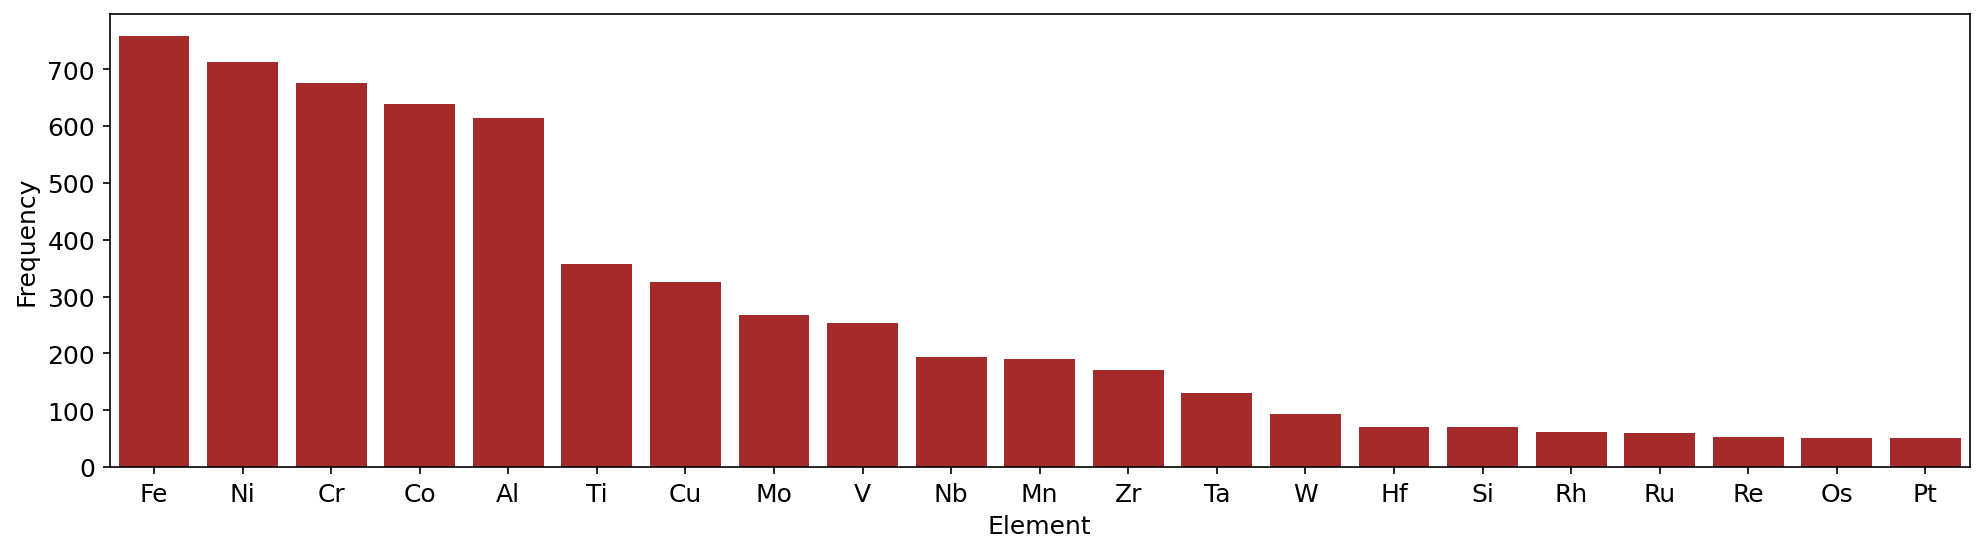

In [10]:
from collections import Counter
all_elements = []
# for alloy_sep in df.loc[df['Class']==1, 'alloy_sep']:
for alloy_sep in df.loc[:, 'alloy_sep']:
    for ele in alloy_sep:
        all_elements.append(ele)
all_elements = Counter(all_elements)
all_elements = dict(sorted(all_elements.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(16,4),dpi=150)
plt.rcParams.update({'font.size': 12})
keys, values = list(all_elements.keys()), list(all_elements.values())
ind = 45
plt.bar(keys[:ind], values[:ind], color='brown')
plt.xlabel('Element')
plt.ylabel('Frequency')
plt.xlim([-0.5,20.5])
plt.savefig('../figures/element_frequency.pdf')
# plt.legend();

In [ ]:
from collections import Counter
all_elements = []
for alloy_sep in df.loc[df['Class']==0, 'alloy_sep']:
    for ele in alloy_sep:
        all_elements.append(ele)
all_elements = Counter(all_elements)
all_elements = dict(sorted(all_elements.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(16,4),dpi=150)
plt.rcParams.update({'font.size': 16})
keys, values = list(all_elements.keys()), list(all_elements.values())
ind = 45
plt.bar(keys[:ind], values[:ind], color='navy', label='Non SP HEA')
plt.xlabel('Element')
plt.ylabel('Frequency')
plt.legend();

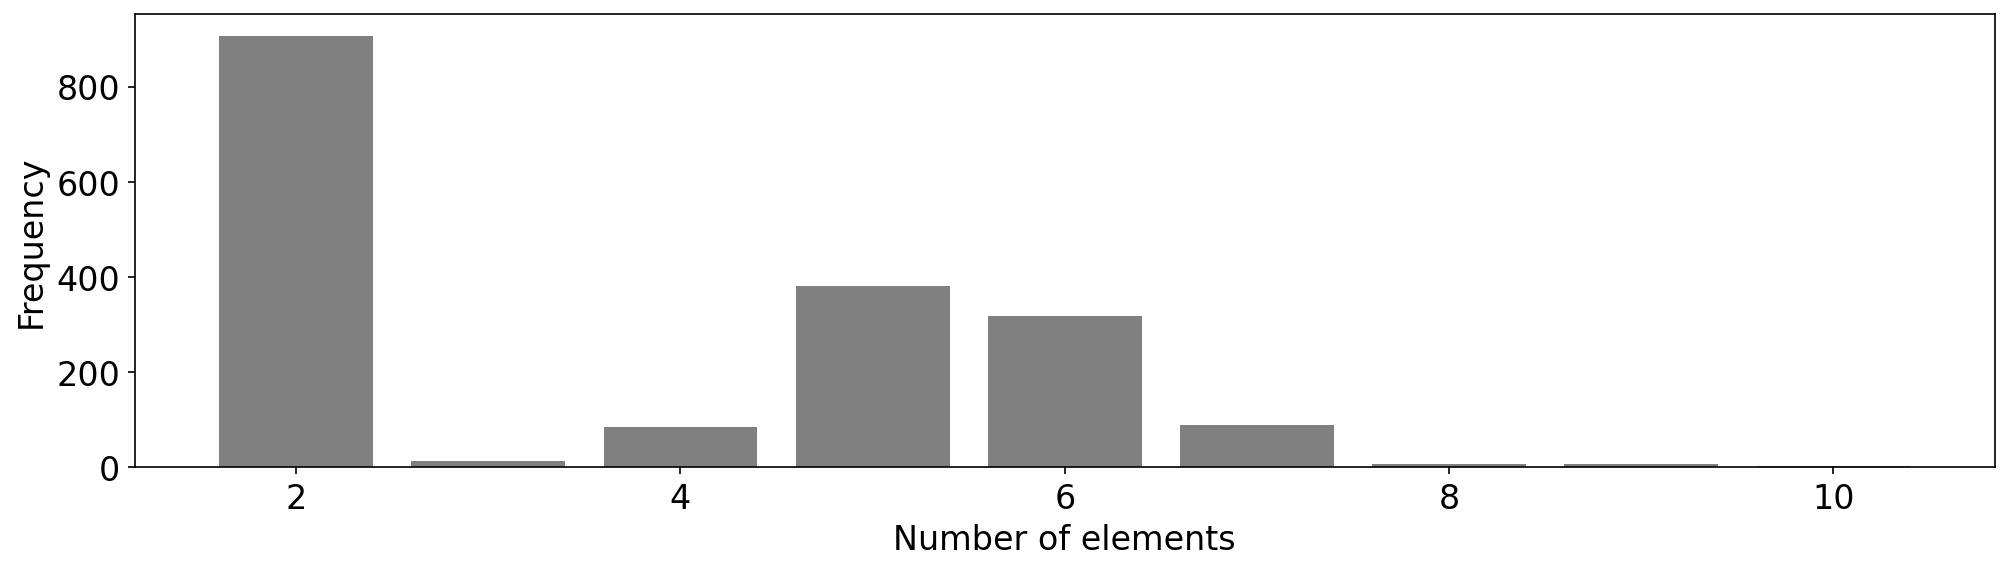

In [11]:
no_elements = []
for alloy_sep in df['alloy_sep']:
    no_elements.append(len(alloy_sep))
no_elements = Counter(no_elements)
no_elements = dict(sorted(no_elements.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(16,4),dpi=150)
plt.rcParams.update({'font.size': 16})
keys, values = list(no_elements.keys()), list(no_elements.values())
ind = 45
plt.bar(keys[:ind], values[:ind], color='gray',)
plt.xlabel('Number of elements')
plt.ylabel('Frequency')
plt.savefig('../figures/number_of_elements.pdf')
# plt.legend();

## Class-specific distribution of numerial features

In [12]:
num_ftrs = ['k','vm','tm','vac','delta','delta_chi', 'delta_s_mix', 'delta_h_mix']
target_ftrs = ['Class']

dict_ftrs_names = {
    'k' : 'Bulk modulus [GPa]', 
    'vm' : r'Atomic volume [cm$^3$/mol]', 
    'tm' : 'Melting temperature [K]', 
    'vac' : 'Valence electron concentration', 
    'delta' : 'Atomic size difference [%]', 
    'delta_chi' : 'Pauling electronegativity difference', 
    'delta_s_mix' : 'Mixing entropy [J/(mol K)]', 
    'delta_h_mix' : 'Mixing enthalpy [kJ/mol]',
    'Class' : 'Is single-phase HEA',         
}

ftrs_names = {
    'k' : 'Bulk modulus', 
    'vm' : 'Atomic volume', 
    'tm' : 'Melting temperature', 
    'vac' : 'Valence electron concentration', 
    'delta' : 'Atomic size difference', 
    'delta_chi' : 'Pauling electronegativity difference', 
    'delta_s_mix' : 'Mixing entropy', 
    'delta_h_mix' : 'Mixing enthalpy',
    'Class' : 'Is single-phase HEA',         
}


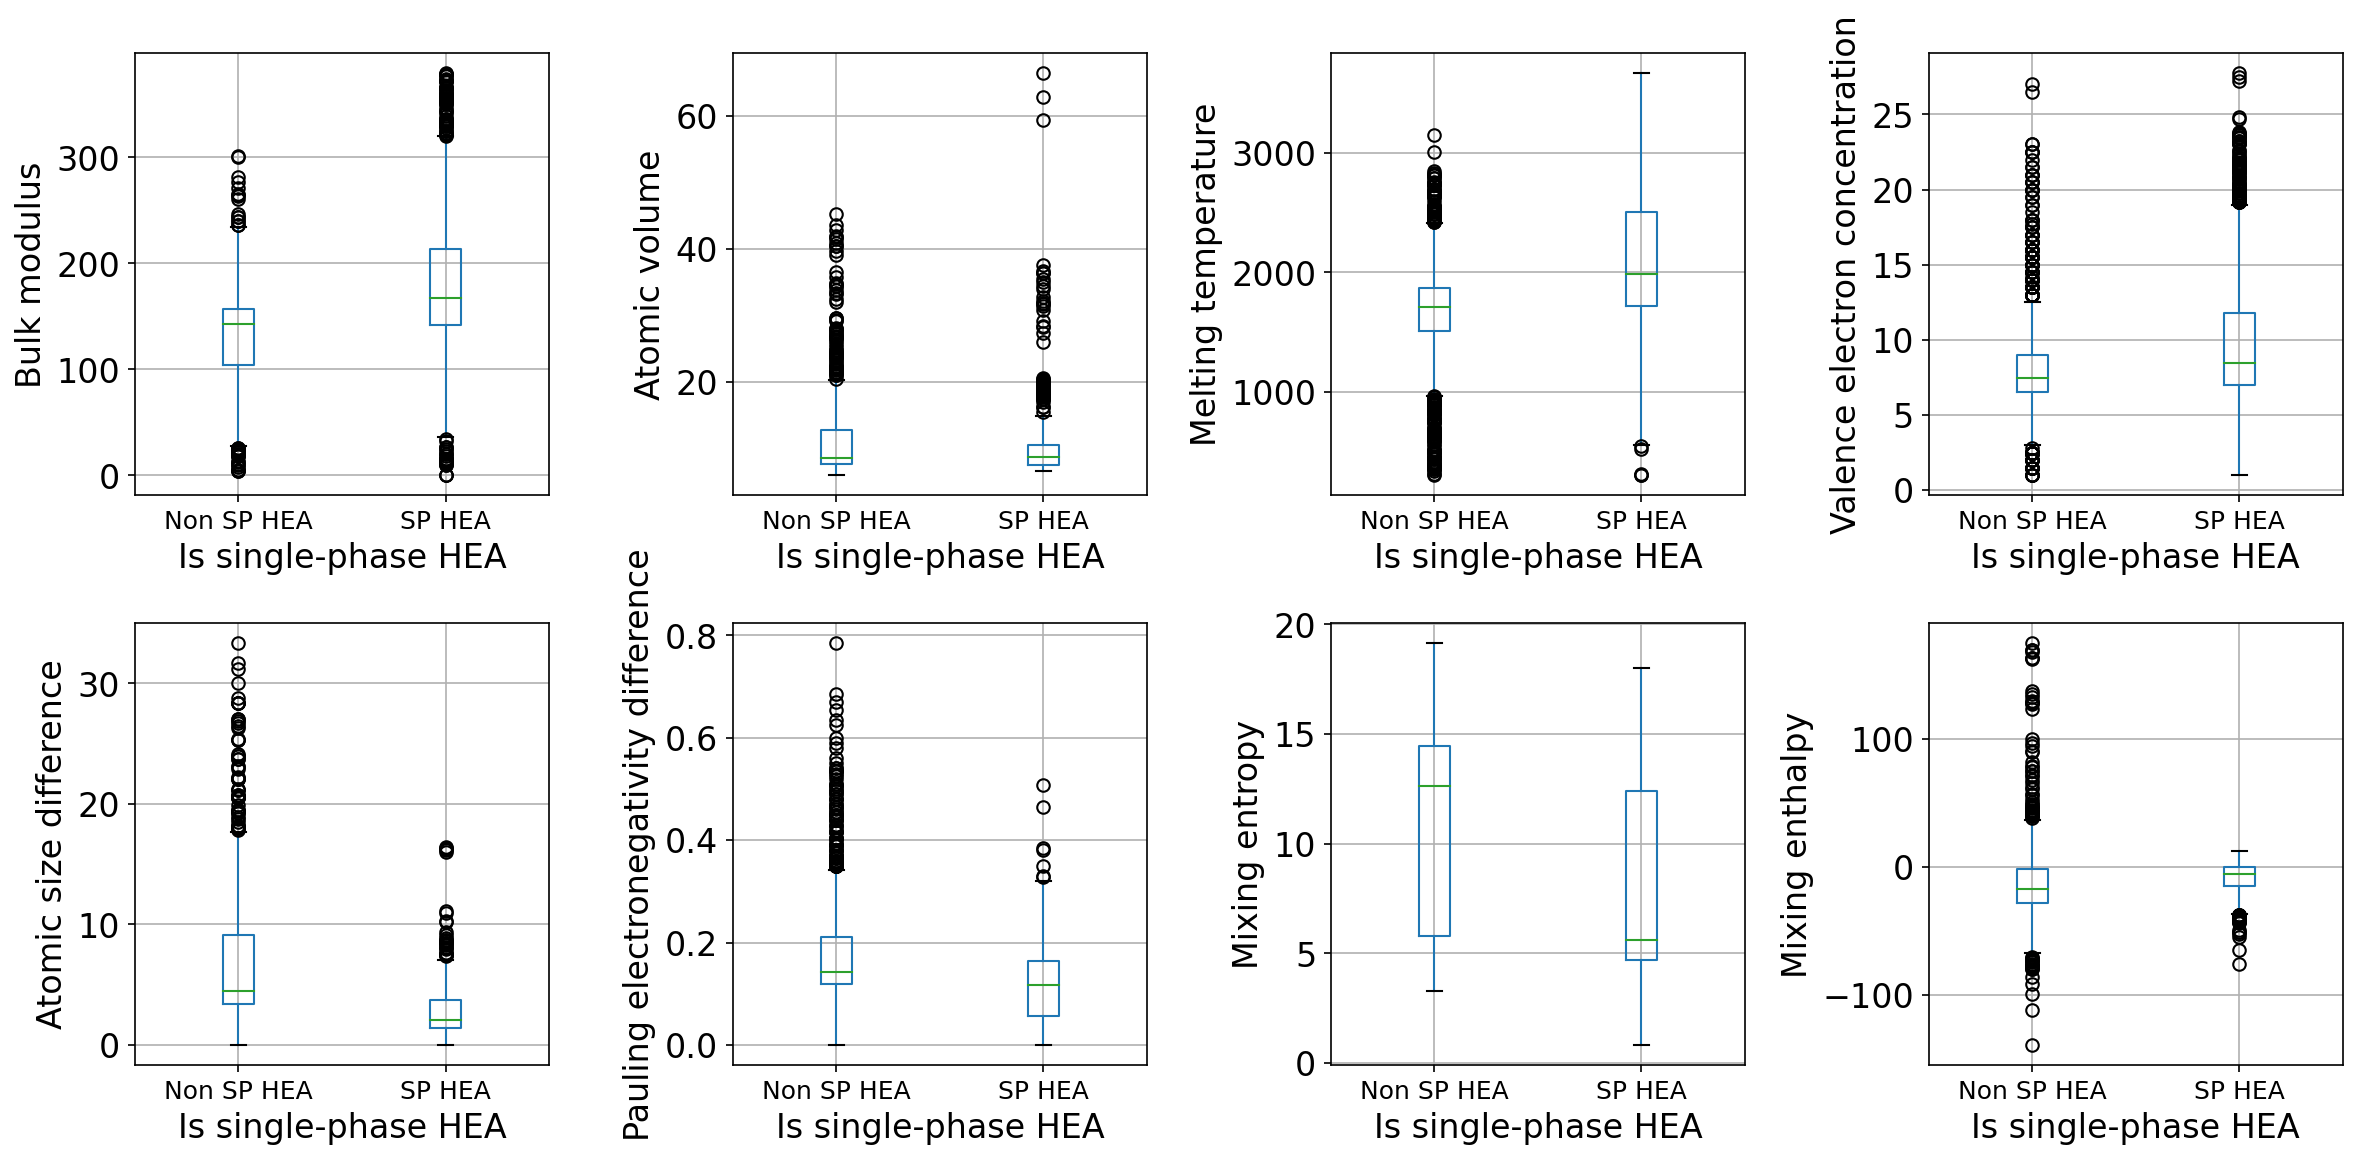

In [13]:
plt.figure(figsize=(16,8),dpi=150)
label = 'Class'
wspace = 0.2   
hspace = 0.2
plt.subplots_adjust(wspace, hspace);
np.random.seed(1234)
for i, feature in enumerate(num_ftrs):
    ax = plt.subplot(2,4,i+1)
    df[[label, feature]].boxplot(by=label, ax=ax)
    ax.set_ylabel(ftrs_names[feature], fontsize=16) 
    ax.set_xlabel(ftrs_names[label], fontsize=16)
    ax.set_xticklabels(['Non SP HEA', 'SP HEA'], 
                       fontsize=12)    
    ax.set_title("")
    fig = ax.get_figure()
    fig.suptitle("")
plt.tight_layout()
plt.savefig('../figures/feature_class.pdf')

## Interaction between feature pairs

<ipython-input-14-e182693c7ae7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ftrs.loc[:, 'y'] = df['Class']


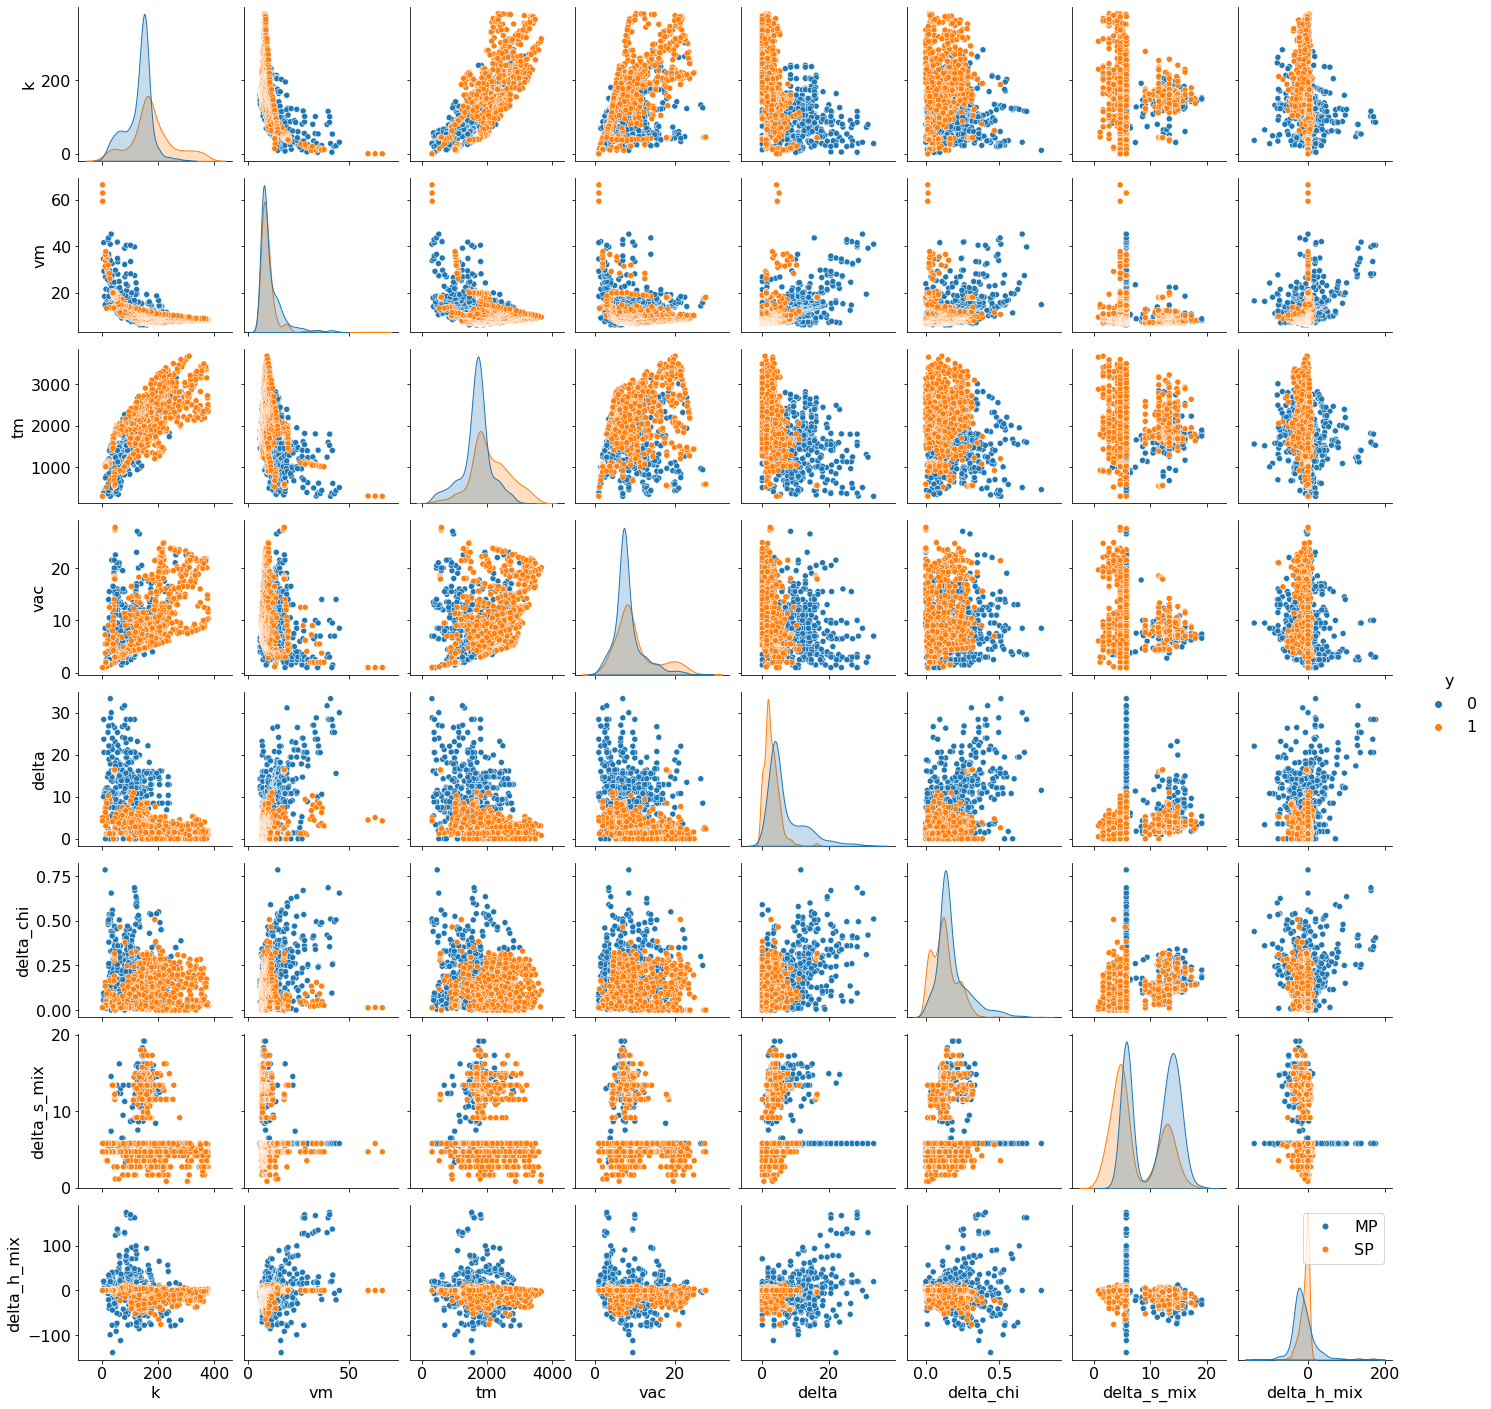

In [14]:
import seaborn as sns
# plt.figure(dpi=500)
# pd.plotting.scatter_matrix(df[num_ftrs],
#                            c = df['Class'], 
#                            figsize=(15, 15), marker='o',
#                            hist_kwds={'bins': 20}, s=60,
#                            alpha=.8,)
# plt.show()
df_ftrs = df[num_ftrs]
df_ftrs.loc[:, 'y'] = df['Class']
g=sns.pairplot(df_ftrs, hue='y')
handles = [plt.plot([],[], ls="", marker=".", \
                    markersize=np.sqrt(100))[0] for i in range(2)]
labels=['MP', 'SP']
plt.legend(labels)
# sns.move_legend(g, "upper left")
# plt.legend(labels=)